In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-17 16:39:29.512959: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:39:29.859672: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:39:29.861718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 16:39:31.156060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [2]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [4]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4409, 38)
(4409, 1)
(537, 38)
(537, 1)
(537, 38)
(537, 1)


In [5]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])

### Model 1: Baseline Model - Linear Regression SGD

</br> Input - Total Emissions
</br>Output - Avg Temp

In [16]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Baseline_SGD')
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Baseline_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
18/18 [==============================] - 0s 7ms/step - loss: 0.9570 - val_loss: 1.4220
Epoch 2/40
18/18 [==============================] - 0s 3ms/step - loss: 0.8262 - val_loss: 1.2774
Epoch 3/40
18/18 [==============================] - 0s 3ms/step - loss: 0.7159 - val_loss: 1.1517
Epoch 4/40
18/18 [==============================] - 0s 3ms/s

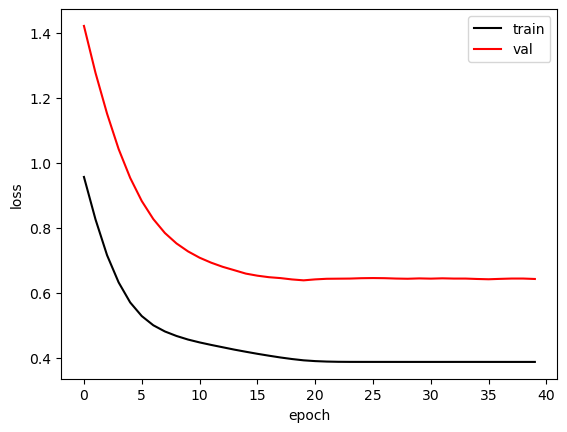

final train mae: 0.387
final val mae:   0.643


In [17]:
model = build_model()
model.summary()

history = model.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=40,
  batch_size=256,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=True)

show_history(history)

### Model 2: Linear Regression (Adam)

</br> Input - Total Emissions
</br>Output - Avg Temp
</br> Requires fewer epochs to converge than standard SGD regression

In [14]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Baseline_Adam')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Baseline_Adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7548 - val_loss: 1.2388
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6243 - val_loss: 1.0609
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5218 - val_loss: 0.9061
Epoch 4/20
18/18 [==============================] - 0s 3ms/

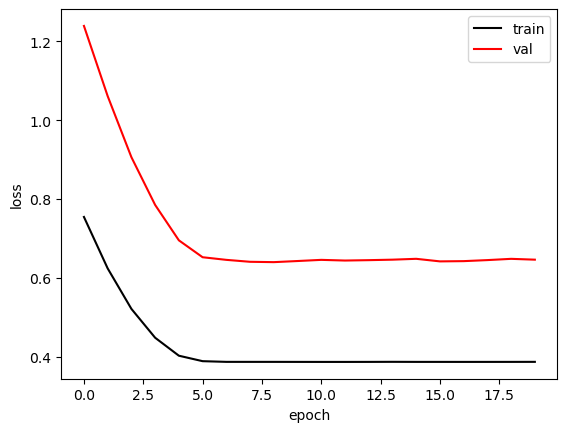

final train mae: 0.388
final val mae:   0.647


In [15]:
model = build_model()
model.summary()

history = model.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=256,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=True)

show_history(history)

### Model 3: Linear Regression (Adam) using Cumulative Sum of Total Emissions

</br> Input - Cumulative Sum of Total Emissions
</br>Output - Avg Temp
</br> Very little difference to Model 2

In [18]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(cum_sum_tot_em)

  model = tf.keras.Model(inputs=[cum_sum_tot_em],
                         outputs=temp,
                         name='Model_3')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Cum Sum Total Emissions (I  [(None, 1)]               0         
 nputLayer)                                                      
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
18/18 [==============================] - 0s 7ms/step - loss: 0.7553 - val_loss: 1.4354
Epoch 2/20
18/18 [==============================] - 0s 3ms/step - loss: 0.6277 - val_loss: 1.2128
Epoch 3/20
18/18 [==============================] - 0s 3ms/step - loss: 0.5272 - val_loss: 1.0065
Epoch 4/20
18/18 [==============================] - 0s 3ms/step -

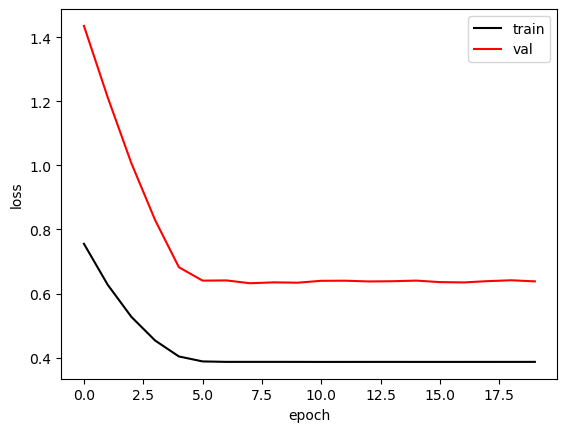

final train mae: 0.387
final val mae:   0.638


In [19]:
model = build_model()
model.summary()

history = model.fit(
  x=x_train[['cum_sum_total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=256,
  validation_data=(
      x_val[['cum_sum_total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=True)

show_history(history)

### Model 4: Linear Regression (Adam) using Cumulative Sum of Total Emissions & Urban Pop

</br> Input - Cumulative Sum of Total Emissions & Urban Population
</br>Output - Avg Temp
</br> Very little difference to model 3

In [20]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')

  features = tf.keras.layers.Concatenate()([cum_sum_tot_em, urban_pop])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[cum_sum_tot_em, urban_pop],
                         outputs=temp,
                         name='Model_4')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Cum Sum Total Emissions (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['Cum Sum Total Emissions[0][0
                                                                    ]',                     

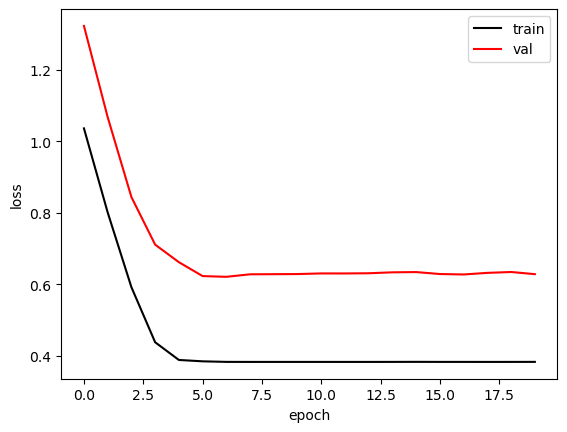

final train mae: 0.383
final val mae:   0.628


In [21]:
model = build_model()
model.summary()

history = model.fit(
  x={
      'Cum Sum Total Emissions': x_train[['cum_sum_total_emission']],
      'Urban Population': x_train[['log_urban_population']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=20,
  batch_size=256,
  validation_data=(
      {
      'Cum Sum Total Emissions': x_val[['cum_sum_total_emission']],
      'Urban Population': x_val[['log_urban_population']]
    },
      Y_val[['average_temperature_°c']]),
  verbose=True)

show_history(history)

### Model 5: Linear Regression (Adam) Kitchen Sink 

</br> Input - Cumulative Sum of Total Emissions & Urban Population
</br>Output - Avg Temp
</br>Some noise in validation loss curve and small difference between val and train

In [41]:
def build_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'East Asia', 'Melanesia','Micronesia', 'Wstern Europe', 
                                                           'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_5')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

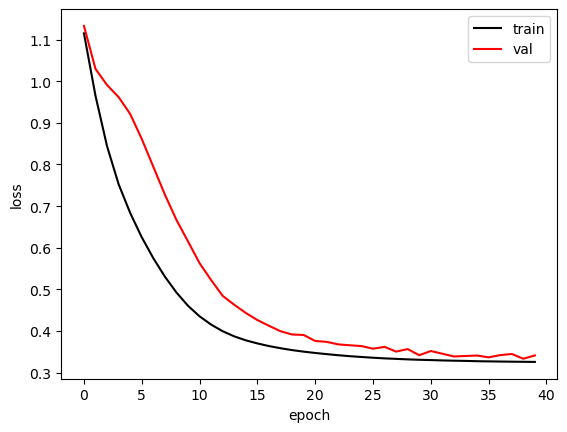

final train mae: 0.326
final val mae:   0.342


In [42]:
model = build_model()
model.summary()

history = model.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=40,
  batch_size=128,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)